### For this project, we will be scraping data from GitHub repository README files. The goal will be to build a model that can predict what programming language a repository is, given the text of the README file.

#### Deliverables

1. A well-documented jupyter notebook that contains your analysis
2. Three or four google slides suitable for a general audience that summarize your findings. Include a well-labelled visualization in your slides.

In [6]:
from requests import get
from bs4 import BeautifulSoup
import os
import re
from env import github_token, github_username
import scraper
import model
import pandas as pd
import json
import seaborn as sns
import time
import prepare_r
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from wordcloud import WordCloud
import nltk
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from scipy import stats

plt.rc('figure', figsize=(10, 6))
plt.rc('font', size=14)
plt.style.use('seaborn-darkgrid')

### Data Acquisition:
1. Acquire list of repos we want to analyze using the scraper.py
2. Use acquire.py (Zach's code) to scrape readme files from Github

In [ ]:
# The acquired data is read from data2.json and store in a dataframe 'df'
f = open('data2.json')
json_file = json.load(f)

df = pd.DataFrame(json_file)

In [ ]:
# We look at df.info() to see how many nulls we have
df.info()

In [2]:
# Looks like there are 35 nulls. We can drop these
df.isnull().sum()

NameError: name 'df' is not defined

In [3]:
# Dropping the nulls
df = df.dropna(axis =0)

NameError: name 'df' is not defined

In [6]:
# Checking again to make sure no more nulls are present 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 245 entries, 1 to 279
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             245 non-null    object
 1   language         245 non-null    object
 2   readme_contents  245 non-null    object
dtypes: object(3)
memory usage: 7.7+ KB


In [7]:
# Resetting index
df = df.reset_index(drop = True)

In [8]:
# Lets look at number of programming languages
df.language.value_counts()

JavaScript          58
Java                33
Python              31
C++                 16
Jupyter Notebook    12
HTML                12
Go                  11
PHP                 11
TypeScript          10
Ruby                 9
CSS                  8
C                    8
Shell                5
Vue                  3
Rust                 2
C#                   2
TeX                  2
Kotlin               2
PowerShell           2
R                    2
Dart                 1
Groovy               1
Objective-C          1
Scala                1
Swift                1
ApacheConf           1
Name: language, dtype: int64

In [9]:
# We filter out the repos with less than 5 languages
df = df.groupby('language').filter(lambda x : len(x)>5)

In [10]:
# Now we are left with repos with following languages
df.language.value_counts()

JavaScript          58
Java                33
Python              31
C++                 16
HTML                12
Jupyter Notebook    12
PHP                 11
Go                  11
TypeScript          10
Ruby                 9
CSS                  8
C                    8
Name: language, dtype: int64

In [11]:
# The function 'other' keeps only certain languages and categorized the others as "Others"
df.language = df.language.apply(prepare_r.other)

In [12]:
df.language.value_counts()

Other         69
JavaScript    58
Java          33
Python        31
C++           16
HTML          12
Name: language, dtype: int64

Text(0, 0.5, 'Programming Language')

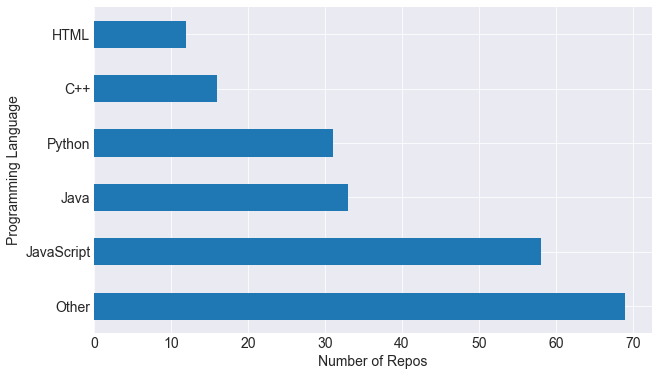

In [13]:
# bar plot showing repo counts by language
df.language.value_counts().plot.barh()
plt.xlabel('Number of Repos')
plt.ylabel('Programming Language')

In [14]:
# Next we drop the column named 'repo' 
df = df.drop(columns = ['repo'])

In [15]:
# We next call a function named 'prep_contents' from prepare.py
df = prepare_r.prep_contents(df)

In [16]:
df.head(2)

,language,readme_contents,original,normalized,stemmed,lemmatized,cleaned
1,HTML,### Well hello there!\n\nThis repository is me...,### Well hello there!\n\nThis repository is me...,well hello there this repository meant pro...,well hello there thi repositori meant provid e...,well hello there this repository meant provide...,well hello repository meant provide example fo...
2,C++,"<div align=""center"">\n <img src=""https://www....","<div align=""center"">\n <img src=""https://www....",div align center img src https www te...,div align center img src http www tensorflow o...,div align center img src http www tensorflow o...,div align center img src tensorflow org image ...


In [17]:
# We will just work with either original content or 'cleaned' column. So we drop other columns
df = df.drop(columns = ['original', 'stemmed', 'normalized', 'lemmatized'])
df = df.reset_index()
df.head(3)

,index,language,readme_contents,cleaned
0,1,HTML,### Well hello there!\n\nThis repository is me...,well hello repository meant provide example fo...
1,2,C++,"<div align=""center"">\n <img src=""https://www....",div align center img src tensorflow org image ...
2,4,JavaScript,"<p align=""center"">\n <a href=""https://getboot...",align center href getbootstrap com img src get...


In [18]:
# Train/test split before exploration
train, test = train_test_split(df, stratify=df.language, test_size=.2, random_state=123)

## Exploration: We will do exploration on train dataset
***

In [59]:
# Which words appear most often in the corpus?
word_counts = pd.Series(" ".join(train.cleaned).split()).value_counts().head(15)
word_counts

com        9172
org        1773
img        1149
doc        1116
python     1088
master     1000
svg         988
code        952
api         941
src         917
use         882
file        877
html        857
library     851
data        821
dtype: int64

Text(0.5, 1.0, '15 most common words in GitHub Readme.md')

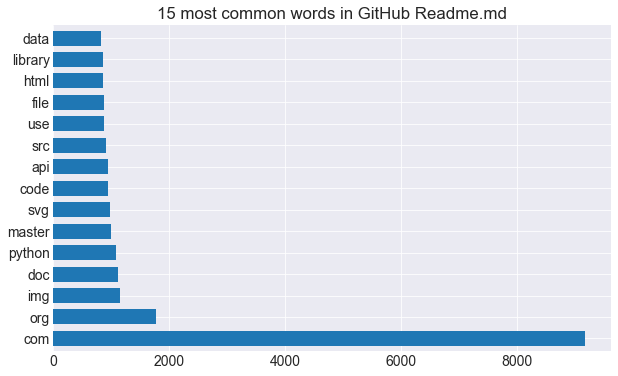

In [65]:
plt.figure(figsize = (10,6))
word_counts.plot.barh(width=0.7)
plt.title('15 most common words in GitHub Readme.md')

In [66]:
#IDF function
def idf(word):
    n_occurences = sum([1 for doc in train.cleaned if word in doc])
    return len(train.cleaned) / n_occurences

In [67]:
#Find unique word list from DF cleaned column
unique_words = pd.Series(' '.join(train.cleaned).split()).unique()
unique_words

array(['python', 'server', 'com', ..., 'happyholidaysto',
       'happycustomholidayto', 'holidaycountdown'], dtype=object)

In [68]:
# make a data frame for unique words
idf_train = pd.DataFrame(dict(word = unique_words))\
.assign(idf = lambda train: train.word.apply(idf))\
.set_index('word').sort_values(by='idf', ascending = False)

In [69]:
idf_train.head(10)

,idf
word,
holidaycountdown,175.0
myapps,175.0
gurkankaymak,175.0
launching,175.0
ahoy,175.0
wordmark,175.0
hocon,175.0
hjson,175.0
intuitcom,175.0


Text(0.5, 0, 'IDF value')

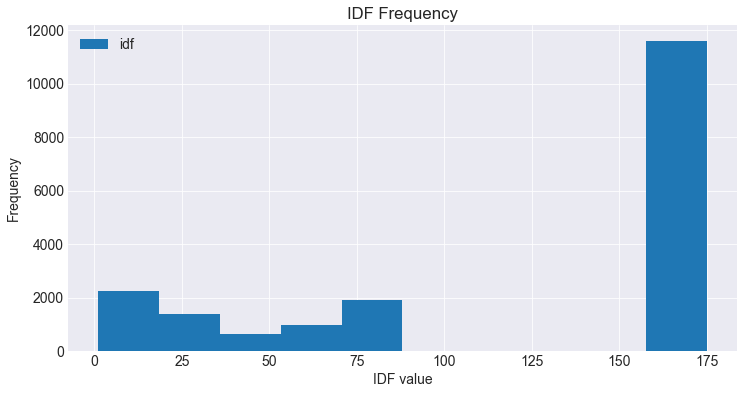

In [70]:
idf_train.plot.hist(figsize=(12,6))
plt.title('IDF Frequency')
plt.xlabel('IDF value')

In [72]:
# Next we create a new column with number of words for each readme file.
train['readme_words'] = train['cleaned'].apply(lambda x: len(x.split()))

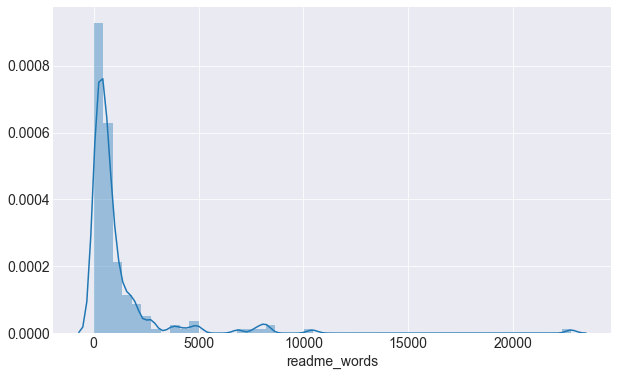

In [73]:
# Plot the distribution of number of words in readme files
sns.distplot(train.readme_words)

The distribution is normal but right skewed

(0, 10000)

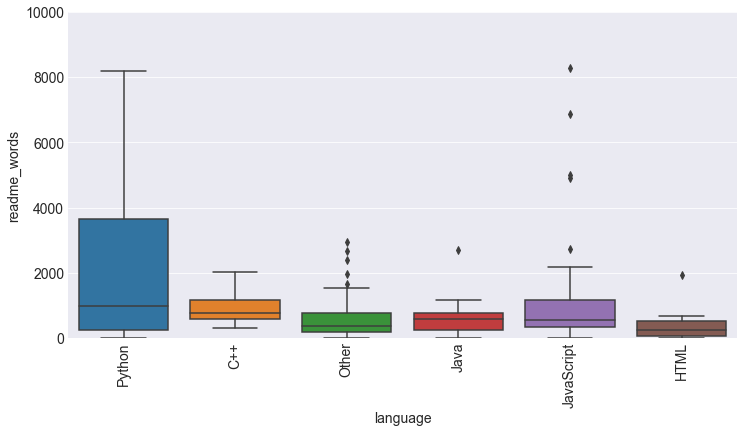

In [74]:
# BoxPlot of number of word by language
plt.figure(figsize = (12,6))
sns.boxplot(x = 'language', y = 'readme_words', data = train)
plt.xticks(rotation = 90)
plt.ylim(0,10000)

(0, 5000)

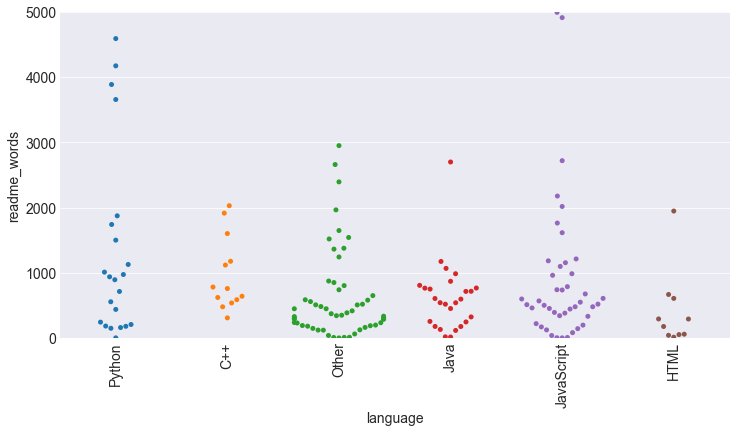

In [75]:
# SwarmPlot of number of word by language
plt.figure(figsize = (12,6))
sns.swarmplot(x = 'language', y = 'readme_words', data = train)
plt.xticks(rotation = 90)
plt.ylim(0,5000)

#### It seems like the median length of readme file is not very different between languages. Python however seems to have much bigger spread. We can do statistical testing:

#### T- test to see if mean of number of words for Python and Javascript is any different:

H_0: The mean number of words between Python and Javascript is same.\
H_a: The mean number of words between Python and Javascript is different.

In [190]:
# T-test 
x1 = train[train.language == 'Python'].readme_words
x2 = train[train.language == 'JavaScript'].readme_words
stats.ttest_ind(x1, x2)

Ttest_indResult(statistic=1.2609780430855242, pvalue=0.21156378450034752)

#### Since p >0.05 we fail to reject the null hypothesis
***

#### T- test to see if mean of number of words for Other and Javascript is any different:

H_0: The mean number of words between Other and Javascript is same.\
H_a: The mean number of words between Other and Javascript is different.

In [187]:
x1 = train[train.language == 'Other'].readme_words
x2 = train[train.language == 'JavaScript'].readme_words
stats.ttest_ind(x1, x2)

Ttest_indResult(statistic=-0.6771665607182691, pvalue=0.49987960999356507)

#### Since p >0.05 we fail to reject the null hypothesis
****

In [76]:
# We will explore all the words that appear in cleaned readme column
All_words = pd.Series(' '.join(train.cleaned).split()).value_counts()
JavaScript_words = pd.Series(' '.join(train[train.language == 'JavaScript'].cleaned).split()).value_counts()
Other_words = pd.Series(' '.join(train[train.language == 'Other'].cleaned).split()).value_counts()
Python_words = pd.Series(' '.join(train[train.language == 'Python'].cleaned).split()).value_counts()
java_words = pd.Series(' '.join(train[train.language == 'Java'].cleaned).split()).value_counts()
Cplus_words = pd.Series(' '.join(train[train.language == 'C++'].cleaned).split()).value_counts()
HTML_words = pd.Series(' '.join(train[train.language == 'HTML'].cleaned).split()).value_counts()


In [79]:
# Making a dataframe and sort values by "All column"
word_counts = (pd.concat([All_words, JavaScript_words, Other_words, Python_words,java_words, Cplus_words,\
                         HTML_words],\
                         axis=1, sort=True).set_axis(['All','JavaScript', 'Other', 'Python','Java', 'C++',\
                         'HTML'], axis=1, inplace=False).fillna(0)\
               .apply(lambda s: s.astype(int)))

word_counts.sort_values(by='All', ascending=False).head(15)

,All,JavaScript,Other,Python,Java,C++,HTML
com,9172,2093,3264,2627,582,480,126
org,1773,492,350,493,131,280,27
img,1149,681,157,136,127,39,9
doc,1116,307,173,297,231,95,13
python,1088,2,236,787,5,57,1
master,1000,185,387,198,90,134,6
svg,988,615,168,66,71,64,4
code,952,205,393,244,42,47,21
api,941,207,225,419,49,40,1
src,917,679,77,72,57,28,4


In [81]:
#Words counts sorted by JavaScript
word_counts.sort_values(by='JavaScript', ascending=False).head(15)

,All,JavaScript,Other,Python,Java,C++,HTML
com,9172,2093,3264,2627,582,480,126
opencollective,768,713,14,1,14,26,0
webpack,733,713,20,0,0,0,0
img,1149,681,157,136,127,39,9
src,917,679,77,72,57,28,4
false,671,647,9,11,1,0,3
svg,988,615,168,66,71,64,4
javascript,718,613,26,8,2,9,60
href,749,534,69,89,38,14,5
requireactive,524,524,0,0,0,0,0


In [82]:
word_counts.sort_values(by='Python', ascending=False).head(15)

,All,JavaScript,Other,Python,Java,C++,HTML
com,9172,2093,3264,2627,582,480,126
python,1088,2,236,787,5,57,1
yes,670,7,2,661,0,0,0
unknown,565,0,4,561,0,0,0
org,1773,492,350,493,131,280,27
api,941,207,225,419,49,40,1
model,470,8,54,398,2,8,0
data,821,202,177,372,52,14,4
youtube,404,16,10,367,5,6,0
video,390,15,52,313,1,0,9


### We see certain words which are very JavaScript specific e.g. 'opencollective', 'webpack'  or very Python Specific e.g. 'yes', 'youtube', 'unknown' etc. We can do a word cloud here

Text(0.5, 1.0, 'Word cloud for all words')

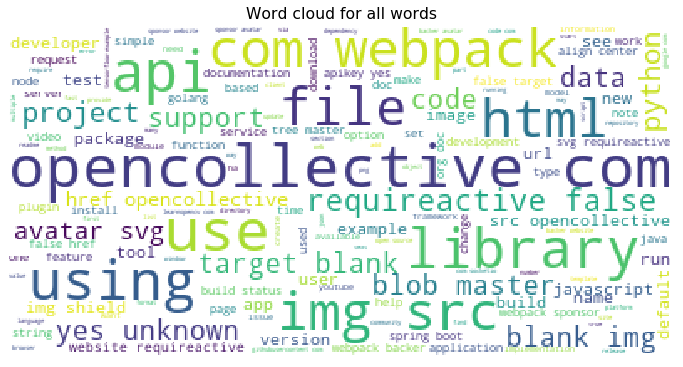

In [41]:
# word cloud for all words
img = WordCloud(background_color='white').generate(' '.join(train.cleaned))
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')
plt.title('Word cloud for all words')

Text(0.5, 1.0, 'Python wordcloud')

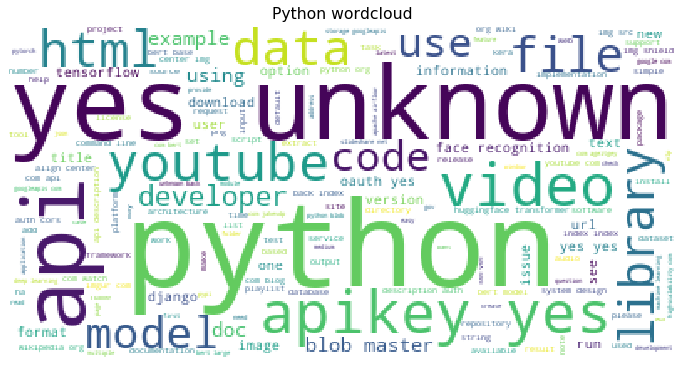

In [42]:
# word cloud for Python
img = WordCloud(background_color='white').generate(' '.join(train[train.language == 'Python'].cleaned))
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')
plt.title('Python wordcloud')

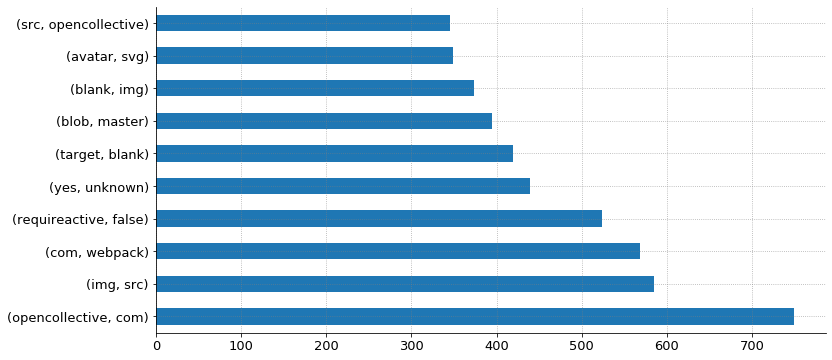

In [43]:
#lets look at bigrams for all text
plt.figure(figsize = (12,6))
bigrams = nltk.ngrams(' '.join(train.cleaned).split(), 2)
pd.Series(bigrams).value_counts().head(10).plot.barh()

In [44]:
top_30_bigrams = pd.Series(nltk.ngrams(' '.join(train.cleaned).split(), 2)).value_counts().head(30)

Text(0.5, 1.0, 'Top 30 Bigrams')

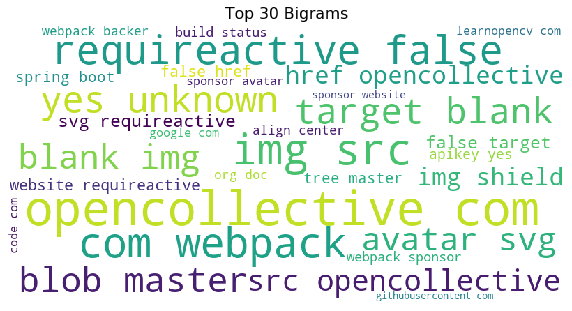

In [45]:
data = {k[0] + ' ' + k[1]: v for k, v in top_30_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.axis('off')
plt.title('Top 30 Bigrams')

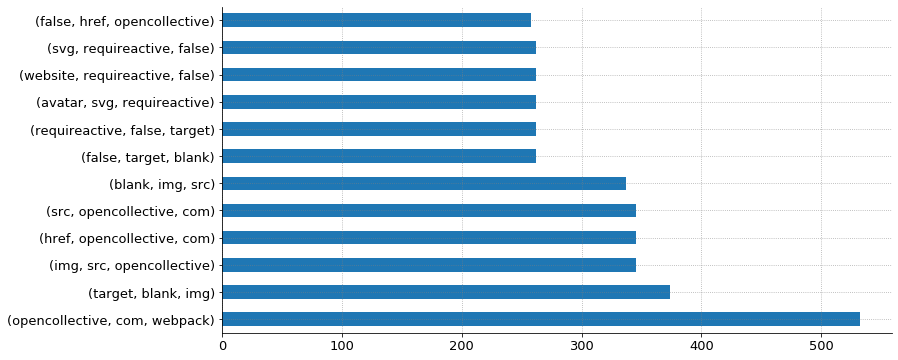

In [46]:
#lets look at trigrams for all text
plt.figure(figsize = (12,6))
bigrams = nltk.ngrams(' '.join(train.cleaned).split(), 3)
pd.Series(bigrams).value_counts().head(12).plot.barh()

In [50]:
top_30_trigrams = pd.Series(nltk.ngrams(' '.join(train.cleaned).split(), 3)).value_counts().head(30)

Text(0.5, 1.0, 'Top 30 Trigrams')

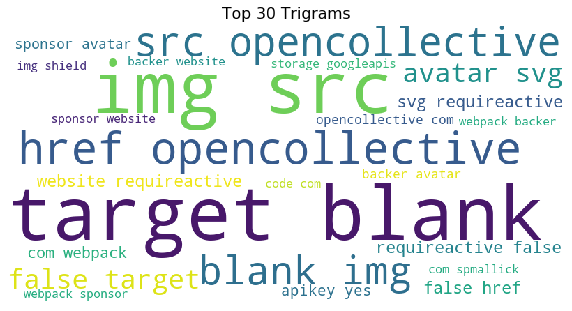

In [51]:
data = {k[0] + ' ' + k[1]: v for k, v in top_30_trigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.axis('off')
plt.title('Top 30 Trigrams')

In [205]:
def digits(text):
    digits = len(re.findall(r'[0-9]', text ))
    return digits    

def link(text):
    link = len((re.findall(r'http', text )))
    return link

def headings1(text):
    return len(re.findall(r'[^#]#[^#]', text))
    
def headings2(text):
    return len(re.findall(r'[^#]##[^#]', text))

def headings3(text):
    return len(re.findall(r'[^#]###[^#]', text))

def headings4(text):
    return len(re.findall(r'[^#]####[^#]', text))

def headings(text):
    return (headings1(text) + headings2(text) + headings2(text) + headings4(text))

In [84]:
train['link'] = train.readme_contents.apply(lambda x: len((re.findall(r'http', x ))))

In [270]:
#Create new features for train dataset
train['headings'] = train.readme_contents.apply(headings)
train['link'] = train.readme_contents.apply(link)
train['digits'] = train.readme_contents.apply(digits)
train['total'] = train['readme_words'] + train['headings']  + train['link']

In [271]:
train.head(3)

,index,language,readme_contents,cleaned,readme_words,link,headings,headings1,headings2,headings4,headings3,digits,total
113,132,Python,### 12306 购票小助手\n#### python版本\n - [ ] 2.7.10...,python server com zhaipro easy pan baidu com v...,161,15,14,3,0,11,0,312,190
3,5,Python,![Logo](https://storage.googleapis.com/model_g...,logo storage googleapis com model garden artif...,208,8,9,3,3,0,0,70,225
218,244,C++,# Tesseract OCR\n\n[![Build Status](https://tr...,tesseract ocr build status travis org tesserac...,782,55,21,3,9,0,0,118,858


(0, 7000)

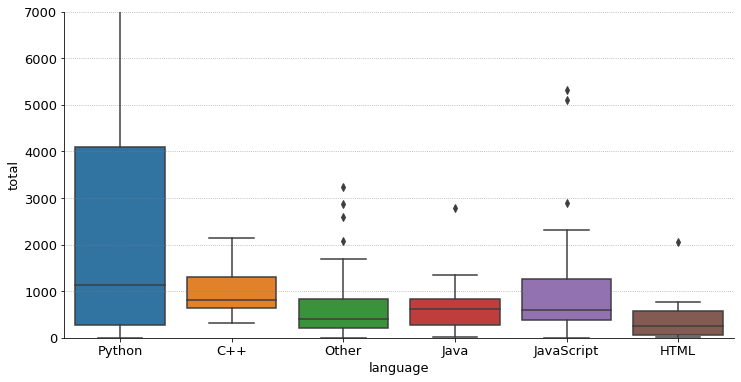

In [272]:
plt.figure(figsize = (12,6))
sns.boxplot(x = 'language', y = 'total', data = train)
plt.ylim(0,7000)

(0, 100)

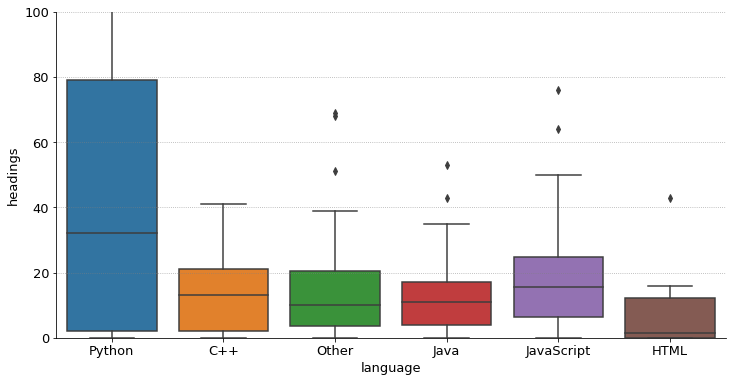

In [265]:
plt.figure(figsize = (12,6))
sns.boxplot(x = 'language', y = 'headings', data = train)
plt.ylim(0,100)

In [245]:
x1 = train[train.language == 'Python'].headings
x2 = train[train.language == 'HTML'].headings
stats.ttest_ind(x1, x2)

Ttest_indResult(statistic=1.6058883937584632, pvalue=0.11782675657943782)

(0, 1000)

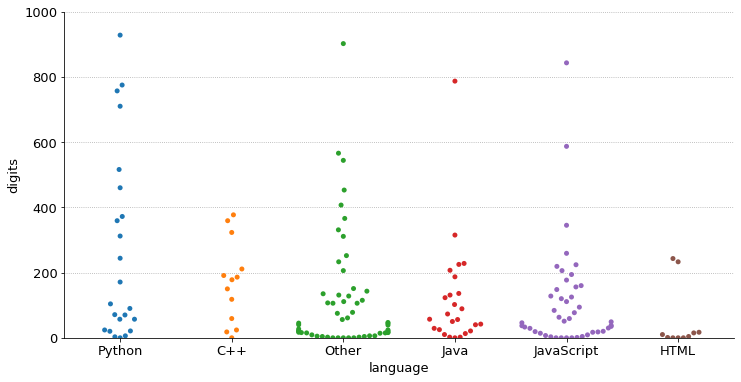

In [56]:
plt.figure(figsize = (12,6))
sns.swarmplot(x = 'language', y = 'digits', data = train)
plt.ylim(0,1000)

(0, 200)

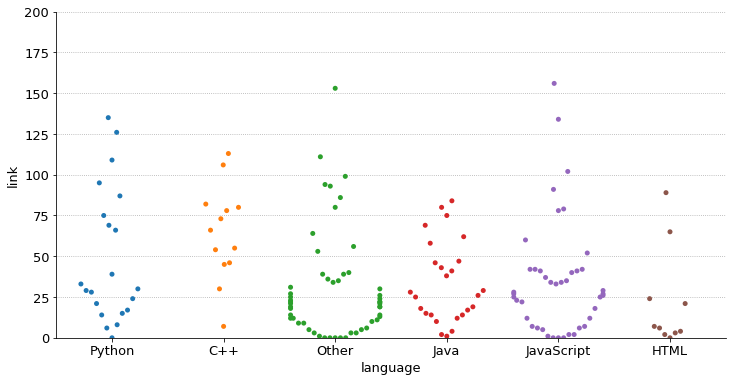

In [57]:
plt.figure(figsize = (12,6))
sns.swarmplot(x = 'language', y = 'link', data = train)
plt.ylim(0,200)

In [58]:
def avg_word(sentence):
    
    words = sentence.split()
    return (sum(len(word) for word in words)/len(words))

In [59]:
train['avg_word'] = train['cleaned'].apply(lambda x: avg_word(x))

(0, 20)

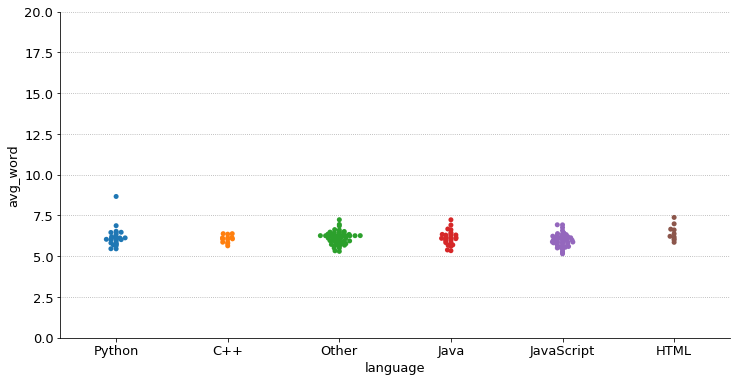

In [60]:
plt.figure(figsize = (12,6))
sns.swarmplot(x = 'language', y = 'avg_word', data = train)
plt.ylim(0,20)

In [61]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

train['stopwords'] = train['readme_contents'].apply(lambda x: len([x for x in x.split() if x in stop]))


(0, 1000)

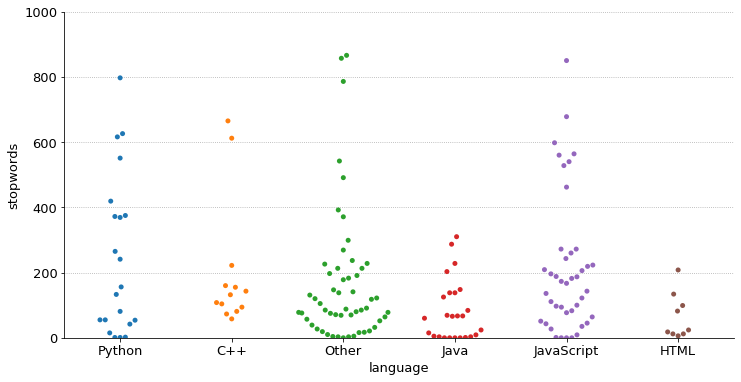

In [62]:
plt.figure(figsize = (12,6))
sns.swarmplot(x = 'language', y = 'stopwords', data = train)
plt.ylim(0,1000)

## Modeling Using Bag of Words

In [293]:
cv = CountVectorizer(ngram_range=(2, 2))
X = cv.fit_transform(df.cleaned)
y = df.language

In [294]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2, random_state = 123)

In [295]:
train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))
clf = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=123)
clf.fit(X_train, y_train)
train['predicted'] = clf.predict(X_train)
test['predicted'] = clf.predict(X_test)

In [296]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 57.50%
---
Confusion Matrix
actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++           8     0     0           0       0
Java          4    10    26          23      13
JavaScript    0     0     0          23       0
Python        1     0     0           0      12
---
              precision    recall  f1-score   support

         C++       1.00      0.62      0.76        13
        HTML       0.00      0.00      0.00        10
        Java       0.34      1.00      0.51        26
  JavaScript       1.00      0.50      0.67        46
      Python       0.92      0.48      0.63        25

    accuracy                           0.57       120
   macro avg       0.65      0.52      0.51       120
weighted avg       0.76      0.57      0.58       120



In [297]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---')
print(classification_report(test.actual, test.predicted))

Accuracy: 40.00%
---
Confusion Matrix
actual      C++  HTML  Java  JavaScript  Python
predicted                                      
Java          2     2     7           9       4
JavaScript    1     0     0           3       0
Python        0     0     0           0       2
---
              precision    recall  f1-score   support

         C++       0.00      0.00      0.00         3
        HTML       0.00      0.00      0.00         2
        Java       0.29      1.00      0.45         7
  JavaScript       0.75      0.25      0.38        12
      Python       1.00      0.33      0.50         6

    accuracy                           0.40        30
   macro avg       0.41      0.32      0.27        30
weighted avg       0.57      0.40      0.36        30



## Modeling

In [298]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df.cleaned)
y = df.language

In [299]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2, random_state = 123)

In [300]:
X_train

<120x16918 sparse matrix of type '<class 'numpy.float64'>'
	with 40803 stored elements in Compressed Sparse Row format>

In [301]:
train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

#### Logistic Regression Model

In [302]:
logit = LogisticRegression(solver = 'liblinear', C = 10).fit(X_train, y_train)
train['predicted'] = logit.predict(X_train)
test['predicted'] = logit.predict(X_test)

In [303]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 100.00%
---
Confusion Matrix
actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++          13     0     0           0       0
HTML          0    10     0           0       0
Java          0     0    26           0       0
JavaScript    0     0     0          46       0
Python        0     0     0           0      25
---
              precision    recall  f1-score   support

         C++       1.00      1.00      1.00        13
        HTML       1.00      1.00      1.00        10
        Java       1.00      1.00      1.00        26
  JavaScript       1.00      1.00      1.00        46
      Python       1.00      1.00      1.00        25

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120



In [304]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---')
print(classification_report(test.actual, test.predicted))

Accuracy: 66.67%
---
Confusion Matrix
actual      C++  HTML  Java  JavaScript  Python
predicted                                      
Java          0     0     3           0       0
JavaScript    1     2     4          12       1
Python        2     0     0           0       5
---
              precision    recall  f1-score   support

         C++       0.00      0.00      0.00         3
        HTML       0.00      0.00      0.00         2
        Java       1.00      0.43      0.60         7
  JavaScript       0.60      1.00      0.75        12
      Python       0.71      0.83      0.77         6

    accuracy                           0.67        30
   macro avg       0.46      0.45      0.42        30
weighted avg       0.62      0.67      0.59        30



#### Decision Tree Classifier

In [305]:
from sklearn.tree import DecisionTreeClassifier
train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

clf = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=123)
clf.fit(X_train, y_train)
train['predicted'] = clf.predict(X_train)
test['predicted'] = clf.predict(X_test)

In [306]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 68.33%
---
Confusion Matrix
actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++           3     0     0           0       0
Java          0     1    16           0       0
JavaScript   10     9    10          46       8
Python        0     0     0           0      17
---
              precision    recall  f1-score   support

         C++       1.00      0.23      0.38        13
        HTML       0.00      0.00      0.00        10
        Java       0.94      0.62      0.74        26
  JavaScript       0.55      1.00      0.71        46
      Python       1.00      0.68      0.81        25

    accuracy                           0.68       120
   macro avg       0.70      0.51      0.53       120
weighted avg       0.73      0.68      0.64       120



In [307]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---')
print(classification_report(test.actual, test.predicted))

Accuracy: 56.67%
---
Confusion Matrix
actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++           0     0     0           1       0
Java          0     0     2           0       0
JavaScript    2     2     5          11       2
Python        1     0     0           0       4
---
              precision    recall  f1-score   support

         C++       0.00      0.00      0.00         3
        HTML       0.00      0.00      0.00         2
        Java       1.00      0.29      0.44         7
  JavaScript       0.50      0.92      0.65        12
      Python       0.80      0.67      0.73         6

    accuracy                           0.57        30
   macro avg       0.46      0.37      0.36        30
weighted avg       0.59      0.57      0.51        30



In [308]:
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_train)

In [309]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

         C++       0.67      0.31      0.42        13
        HTML       0.50      0.30      0.37        10
        Java       0.85      0.85      0.85        26
  JavaScript       0.71      0.87      0.78        46
      Python       0.85      0.88      0.86        25

    accuracy                           0.76       120
   macro avg       0.71      0.64      0.66       120
weighted avg       0.75      0.76      0.74       120



In [310]:
y_pred_test = knn.predict(X_test)
y_pred_test

array(['JavaScript', 'Java', 'Python', 'JavaScript', 'Python',
       'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'Python', 'JavaScript', 'JavaScript',
       'Python', 'Python', 'Python', 'JavaScript', 'JavaScript',
       'JavaScript', 'Java', 'JavaScript', 'JavaScript', 'JavaScript',
       'Java', 'JavaScript', 'JavaScript', 'Python', 'Java', 'Python'],
      dtype=object)

In [311]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

         C++       0.00      0.00      0.00         3
        HTML       0.00      0.00      0.00         2
        Java       0.75      0.43      0.55         7
  JavaScript       0.61      0.92      0.73        12
      Python       0.62      0.83      0.71         6

    accuracy                           0.63        30
   macro avg       0.40      0.44      0.40        30
weighted avg       0.54      0.63      0.56        30



#### Random Forest Classifier

In [312]:
clf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=1000,
                            max_depth=5, 
                            random_state=42)

In [313]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=123)
clf.fit(X_train, y_train)
train['predicted'] = clf.predict(X_train)
test['predicted'] = clf.predict(X_test)

In [314]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 68.33%
---
Confusion Matrix
actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++           3     0     0           0       0
Java          0     1    16           0       0
JavaScript   10     9    10          46       8
Python        0     0     0           0      17
---
              precision    recall  f1-score   support

         C++       1.00      0.23      0.38        13
        HTML       0.00      0.00      0.00        10
        Java       0.94      0.62      0.74        26
  JavaScript       0.55      1.00      0.71        46
      Python       1.00      0.68      0.81        25

    accuracy                           0.68       120
   macro avg       0.70      0.51      0.53       120
weighted avg       0.73      0.68      0.64       120



In [315]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---')
print(classification_report(test.actual, test.predicted))

Accuracy: 56.67%
---
Confusion Matrix
actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++           0     0     0           1       0
Java          0     0     2           0       0
JavaScript    2     2     5          11       2
Python        1     0     0           0       4
---
              precision    recall  f1-score   support

         C++       0.00      0.00      0.00         3
        HTML       0.00      0.00      0.00         2
        Java       1.00      0.29      0.44         7
  JavaScript       0.50      0.92      0.65        12
      Python       0.80      0.67      0.73         6

    accuracy                           0.57        30
   macro avg       0.46      0.37      0.36        30
weighted avg       0.59      0.57      0.51        30



#### MLPClassifier

In [316]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='lbfgs', alpha=1,
                     hidden_layer_sizes=(70,), random_state=123)

clf.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=1, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(70,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=123, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [317]:
clf.predict(X_train)

array(['JavaScript', 'JavaScript', 'JavaScript', 'C++', 'C++', 'Python',
       'C++', 'HTML', 'Python', 'Python', 'JavaScript', 'Java', 'Python',
       'JavaScript', 'Java', 'Python', 'Python', 'JavaScript', 'Java',
       'JavaScript', 'Java', 'JavaScript', 'Java', 'Java', 'Python',
       'HTML', 'JavaScript', 'HTML', 'Java', 'JavaScript', 'JavaScript',
       'JavaScript', 'Python', 'HTML', 'Python', 'JavaScript', 'C++',
       'C++', 'HTML', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'C++', 'JavaScript', 'Java', 'JavaScript',
       'JavaScript', 'C++', 'JavaScript', 'HTML', 'JavaScript', 'Python',
       'JavaScript', 'C++', 'JavaScript', 'JavaScript', 'Python',
       'JavaScript', 'HTML', 'Java', 'Python', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'Java', 'JavaScript', 'Java', 'Python',
       'Python', 'Python', 'HTML', 'JavaScript', 'Java', 'JavaScript',
       'Java', 'Python', 'Python', 'JavaScript', 'JavaScript', 'Python',
       '

In [318]:
clf.score(X_train, y_train)

1.0

In [319]:
clf.score(X_test, y_test)

0.6666666666666666

### Naive Bayes Multinomial Classifier

In [320]:
clf = MultinomialNB(alpha = 0.01)
clf.fit(X_train, y_train)

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

In [321]:
clf.predict(X_train)

array(['JavaScript', 'JavaScript', 'JavaScript', 'C++', 'C++', 'Python',
       'C++', 'HTML', 'Python', 'Python', 'JavaScript', 'Java', 'Python',
       'JavaScript', 'Java', 'Python', 'Python', 'JavaScript', 'Java',
       'JavaScript', 'Java', 'JavaScript', 'Java', 'Java', 'Python',
       'HTML', 'JavaScript', 'HTML', 'Java', 'JavaScript', 'JavaScript',
       'JavaScript', 'Python', 'HTML', 'Python', 'JavaScript', 'C++',
       'C++', 'HTML', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'C++', 'JavaScript', 'Java', 'JavaScript',
       'JavaScript', 'C++', 'JavaScript', 'HTML', 'JavaScript', 'Python',
       'JavaScript', 'C++', 'JavaScript', 'JavaScript', 'Python',
       'JavaScript', 'HTML', 'Java', 'Python', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'Java', 'JavaScript', 'Java', 'Python',
       'Python', 'Python', 'HTML', 'JavaScript', 'Java', 'JavaScript',
       'Java', 'Python', 'Python', 'JavaScript', 'JavaScript', 'Python',
       '

In [322]:
clf.score(X_train, y_train)

1.0

In [323]:
clf.score(X_test, y_test)

0.6666666666666666

### Naive Bayes Bernoulli  Classifer

In [324]:
clf = BernoulliNB(alpha=1)
clf.fit(X_train, y_train)

BernoulliNB(alpha=1, binarize=0.0, class_prior=None, fit_prior=True)

In [325]:
clf.predict(X_train)

array(['JavaScript', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'Python', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'Java', 'JavaScript', 'JavaScript', 'JavaScript',
       'Java', 'JavaScript', 'Java', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'Python', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript', 'Java',
       'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScrip

In [326]:
clf.score(X_train, y_train)

0.5083333333333333

In [327]:
clf.score(X_test, y_test)

0.4